# Invader Defender 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import pickle
from scipy.optimize import linprog
import pandas as pd
import time
import random
import warnings

warnings.filterwarnings('ignore')

In [2]:
actions = [[-1, 0], [0, 1], [1, 0], [0, -1]] #up, right, down, left = (clockwise from up) 
action_count = len(actions) 
gridSize = 6 
state_count = gridSize*gridSize

In [3]:
class Invader_Defender():
    def __init__(self, gridSize):
        self.valueMap = np.zeros((gridSize, gridSize))
        self.states = [[i, j] for i in range(gridSize) for j in range(gridSize)]
        self.size = gridSize
        
        # deterministic transition ?
        self.transition_prob = 1 
        
        # initialize defender and invader states
        self.new_state = [0, 0, 0, 0]
        self.new_defender_state = [0, 0]
        self.new_invader_state = [0, 0]
        
        # set territory state
        self.territory_state = [4, 4]

        # create a list of all possible states in the game
        self.game_state_list = []
        for defender_state in self.states:
            for invader_state in self.states:
                combined_states = tuple(defender_state + invader_state)
                self.game_state_list.append(combined_states)
        
        # create 2 lists of states representing defender and invader victory
        self.defender_won = []
        self.invader_won = []
        
        # create states representing defender victory
        for defender_state in self.states:
            for invader_state in self.states:
                distance = np.linalg.norm(np.array(defender_state) - np.array(invader_state))
                # if the invader is not at territory and within the capture range of defender = defender won
                if invader_state != self.territory_state and distance <= np.sqrt(2):
                    combined_states = defender_state + invader_state
                    self.defender_won.append(combined_states)
                    
        # create states representing invader victory = anytime invader is at territory
        for defender_state in self.states:               
            combined_states = defender_state + self.territory_state
            self.invader_won.append(combined_states)
            
    def initial_states(self):
        "returns initial states of invader and defender"
        defender_state = [gridSize-1,0]
        invader_state = [0,0]
        return tuple(defender_state+invader_state)    
    
    def possible_states(self):
        """
        A function that returns a list of all possible states in the game
        """
        return self.game_state_list
    
    def terminal_check(self, state):
        """
        A function that checks whether the game is at a terminal state.
        Terminal state happens when either the invader or defender has won.
        """
        if state in self.defender_won:
            status = "Defender Won"
            terminal_check = True
        elif state in self.invader_won:
            status = "Invader Won"
            terminal_check = True
        else:
            terminal_check = False
            status = "Game in Progress"

        return terminal_check, status
    
#     def transition_probability(self, transition):
#         """
#         A function that returns the transition probability...?
#         """
#         return self.transition_prob, reward

    def next_state(self, current_state, defender_action, invader_action):
        """
        A function that returns the next state
        Input: current state [0,0] , defender_action [0, 1], invader_action [0,-1]
        Output: next state array([x1,y1,x2,y2]) and reward (int)
            - If the action takes the agent off grid, the agent remains in original state
            - If defender won, reward is calculated based on manhattan distance between invader captured state
            and territory
            - If defender loss, reward is -100
        """
        defender_state = []
        invader_state = []
        
        # deconstruct current state [0,0,1,1] in to defender [0,0] and invader [1,1] state
        for i in range(4):
            if i < 2:
                defender_state.append(current_state[i])
            else:
                invader_state.append(current_state[i])
                
        # get next state: state: [0, 0], action: [0, 1], new_state = [0, 1]
        self.new_defender_state = list(np.array(defender_state) + np.array(defender_action))
        self.new_invader_state = list(np.array(invader_state) + np.array(invader_action))

        # if new defender states results in off the grid, return to original state
        if -1 in self.new_defender_state or self.size in self.new_defender_state:
            self.new_defender_state = defender_state
        
        # if new invader states results in off the grid, return to original state
        if -1 in self.new_invader_state or self.size in self.new_invader_state:
            self.new_invader_state = invader_state
       
        # combine the defender and invader state
        self.new_state = self.new_defender_state
        self.new_state.extend(self.new_invader_state)
        
        # calculate rewards
        terminal, status = self.terminal_check(self.new_state)
        if terminal == True:
            if status == "Defender Won":
                # defender reward if defender won (manhattan distance between invader captured state and territory)
                distance_to_territory = sum(abs(np.array(self.new_invader_state) - np.array(self.territory_state)))
                self.reward = distance_to_territory
            else:
                # defender reward if invader won
                self.reward = -100
        else:
            self.reward = 0
        
        return self.new_state, self.reward

## Initialization and Function Definitions

In [4]:
invader_defender = Invader_Defender(6)

In [5]:
# initialize params
state_list = []
delta_list = []
t = 0
T = 200
lr = 0.9
gamma = 0.99
epsilon = 0.5
tolerance = 1e-6
runs = 1
r=0
episodes = 2000
agentNum = 2

In [6]:
def calculate_payoff(state):
    """
    A function calculates the payoff of a specific state based on Q values
    Input: state (ie. [0,0,1,1])
    Output: payoff = 4x4 matrix where each element represent the defender's payoff 
    when defender take i, and invader take action j
    """
    state = list(state)
    payoff = np.zeros([4,4])
    for i in range(action_count):
        defender_action = i
        for j in range(action_count):
            invader_action = j
            joint_action = [defender_action, invader_action]
            state_action_pair = tuple(state + joint_action)
            payoff[i, j] = Q[state_action_pair]

    return payoff

In [7]:
def calculate_value(G_state):
    """
    A function that calculates the value of a game by using linear programming.
    The value is calculated in both the defender and invader's perspective which are equal in value
    and opposite in signs
    Input: payoff matrix of a particular state (4x4 matrix)
    Output: Value = scalar value of the game.
    """
    
    G_state = list(G_state)
    
    # defender lin prog
    c = [0, 0, 0, 0, -1]
    defender_q = -1*np.transpose(G_state)     
    v_coeff = np.ones((4,1))
    Aub = np.concatenate((defender_q,v_coeff),1)
    b = [0, 0, 0, 0]
    Aeq = [[1, 1, 1, 1, 0]]
    beq = [[1.]]
    bounds = ((0,1),(0,1),(0,1),(0,1),(None, None))
    defender_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='revised simplex')
    
    # invader lin prog
    c = [0, 0, 0, 0, 1]
    invader_q = G_state
    w_coeff = np.ones((4,1))*-1
    Aub = np.concatenate((invader_q,w_coeff),1)
    invader_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='revised simplex')
        
    # check if the linprog solution is successful or not
    if defender_solution['status'] == 0:
        value = defender_solution['fun']*-1
    else:
        value = invader_solution['fun']
    
    return value

In [8]:
def equilibrium(G_state):
    """
    A function that obtains the policy for defender and invader
    The value is calculated in both the defender and invader's perspective which are equal in value
    and opposite in signs
    Input: payoff matrix of a particular state (4x4 matrix)
    Output: policy for defender and invader
    """
    
    # defender lin prog
    c = [0, 0, 0, 0, -1]
    defender_q = -1*np.transpose(G_state)     
    v_coeff = np.ones((4,1))
    Aub = np.concatenate((defender_q,v_coeff),1)
    b = [0, 0, 0, 0]
    Aeq = [[1, 1, 1, 1, 0]]
    beq = [[1.]]
    bounds = ((0,1),(0,1),(0,1),(0,1),(None, None))
    defender_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='revised simplex')
    
    # invader lin prog
    c = [0, 0, 0, 0, 1]
    invader_q = G_state
    w_coeff = np.ones((4,1))*-1
    Aub = np.concatenate((invader_q,w_coeff),1)
    invader_solution = linprog(c, A_ub=Aub, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds, method='revised simplex')
    
    if defender_solution['status'] == 0:
        defender_policy = defender_solution['x'][:4]
    else:
        defender_policy = np.array([0.25,0.25,0.25,0.25])
    
    if invader_solution['status'] == 0:
        invader_policy = invader_solution['x'][:4]
    else:
        invader_policy = np.array([0.25,0.25,0.25,0.25])

    return defender_policy, invader_policy

# Minimax Q-learning

In [9]:
#Initialize list
state_action_pair_list = []

# create every possible state action pairs: 
# 1296 states * 4 defender actions * 4 invader actions = 20736 s,a pairs
for state in invader_defender.game_state_list:
    for defender_action in range(action_count):
        for invader_action in range(action_count):
            joint_action = [defender_action, invader_action]
            state_action_pair = list(state) + joint_action
            state_action_pair_list.append(tuple(state_action_pair))


while r < runs:

    #Initialize Q {(x1, y1, x2, y2, defender_action_index, invader_action_index): q_value}
    listofzeros = [0.0] * len(state_action_pair_list)
    Q = dict(zip(state_action_pair_list, listofzeros))
    
    #Initialize dictionary for games  {(x1, y1, x2, y2): payoff_matrix}           
    listofzeros = [0.0] * len(invader_defender.game_state_list)
    for state in invader_defender.game_state_list:
        state_list.append(state)
    G = dict(zip(state_list, listofzeros))      
     
    # initialize policies
    initial_policy = []
    defender_policy = {}
    invader_policy = {}         
    # random initial policy
    for i in range(len(invader_defender.game_state_list)):
        random_policy = np.array([0.25, 0.25, 0.25, 0.25])
        initial_policy.append(random_policy)
    defender_policy = dict(zip(state_list, initial_policy))
    invader_policy = dict(zip(state_list, initial_policy))
    
    # Ini delta
    delta = 0
     
    
    #Ini for collecting rewards         
    accumulatedRewards = [] 
    for n in range(agentNum):
        accumulatedRewards.append(0.0)
             
    # initialize the next entry of the U dictionary
    for ep in range(episodes):
        #print("run", r, "Episode", ep)
        current_state = invader_defender.initial_states()
        terminal = False
        steps = 0
        while terminal == False and steps<200:

        #1 get actions
            G[current_state] = calculate_payoff(current_state) 

            p, q = equilibrium(G[current_state])    #initial policy       
            actioni = np.argmax(p)   #choose actions
            actiond = np.argmax(q)
            #random action for exploration
            if np.random.binomial(1, epsilon) == 1:
                actiondex = np.random.choice(action_count)
                while actiondex == actiond:
                    actiondex = np.random.choice(action_count)
                actiond = actiondex
                actioniex = np.random.choice(action_count)
                while actioniex == actioni:
                    actioniex = np.random.choice(action_count)
                actioni = actioniex
         
        #2 find next state and reward
            next_state, reward = invader_defender.next_state(current_state, actions[actiond], actions[actioni])
            
            next_state = tuple(next_state)
            
        #3 Calculate the value of the game next state     
            
            G[next_state] = calculate_payoff(next_state)
            p2, q2 = equilibrium(G[next_state])
            
            #Value of the game to update Qj v=pT*A*q
            ai = np.transpose(p2)
            dotai=np.dot(ai,G[current_state])
            value = np.dot(dotai,q2)
        
        #4 Update Qj 
            #backup old Q
            joint_action = [actiond, actioni]
            current_state_action_pair = tuple(list(current_state) + joint_action)
            #print(Q[(0, 0, 5, 0, -1, 0, -1, 0)])
            Q_copy = Q[current_state_action_pair]
        
            Q[current_state_action_pair] = Q_copy + lr*(reward + gamma*value - Q_copy)
            
            # calculate delta
            delta = max(delta, abs(Q[current_state_action_pair] - Q_copy))
         
        #5 Update new joinState
            current_state = next_state
            steps = steps + 1
        #6 check terminal condition
            terminal, status = invader_defender.terminal_check(current_state)
            if steps < 200 and terminal == True:
                print(status)
            elif steps == 200 :
                print("max steps exceed")
                #clear_output(wait=True)
            clear_output(wait=True)
            print('run: ', r, ' episode: ', ep, ' delta: ', delta)
            
        delta_list.append(delta) 
       #Reset for testing
        terminal = False
        jointState = invader_defender.initial_states()
       #count for discounted rewards
        count = 0
        print("testing")
       #Run testing 
        while terminal == False and count < 200:
           
       #initial join state 
       
       #1: get actions 
            G[current_state] = calculate_payoff(current_state) 
            p, q = equilibrium(G[current_state])    #initial policy       
            actioni = np.argmax(p)   #choose actions
            actiond = np.argmax(q)
       #2: Find nextstate and reward 
            next_state, reward = invader_defender.next_state(current_state, actions[actiond], actions[actioni])
            next_state = tuple(next_state)
       #3: Collect reward
            for a in range(agentNum):
                if a == 0:
                    accumulatedRewards[a] =+ (gamma**count)*reward
                else: 
                    accumulatedRewards[a] =+ (gamma**count)*-1*reward
       #4: Update state
            current_state = next_state

           
       #5: check terminal condition
            terminal, status  = invader_defender.terminal_check(current_state)
            count = count + 1 
            if count < 200 and terminal == False:
                print(status)
            else:
                print("max steps exceed")
               
     #     print k and current max delta
       
    r=r+1
        
print("rewards 1", accumulatedRewards[0])
print("rewards 2", accumulatedRewards[1])

run:  0  episode:  1999  delta:  252.52295446687503
testing
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game in Progress
Game 

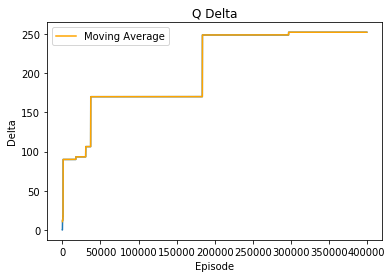

In [17]:
plt.plot(delta_list)
plt.title('Q Delta')
plt.xlabel('Episode')
plt.ylabel('Delta')

# plot moving average
reward_frame = pd.DataFrame(delta_list)
rolling_mean = reward_frame.rolling(window=50).mean()
plt.plot(rolling_mean, label='Moving Average', color='orange')
plt.legend()
plt.show()

## HEATMAP

In [18]:
# create Q_state_dict = {(x1,y1,x2,y2): [1,2,3....16]} where 1-16 represent the Q values 
# of each defender invader action combination

Q_state_list = []

for state in invader_defender.game_state_list:
    Q_state = []
    for defender_action in range(action_count):
        for invader_action in range(action_count):
            state_action_pair = tuple(list(state) + [defender_action, invader_action])
#             print(state_action_pair)
            Q_state.append(Q[state_action_pair])
    Q_state_list.append(Q_state)
Q_state_dict = dict(zip(state_list, Q_state_list))

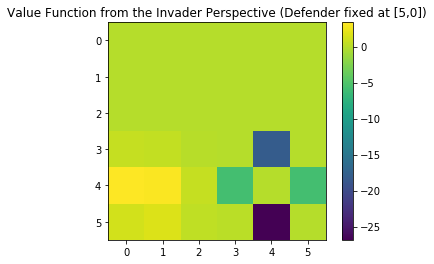

In [23]:
fixed_defender_state_list = []
for invader_state in invader_defender.states:
    fixed_defender_state = tuple([5, 0] + invader_state)
    fixed_defender_state_list.append(fixed_defender_state)
invader_map = np.zeros([6,6])
for state in fixed_defender_state_list:
    invader_map[state[2], state[3]] = np.mean(Q_state_dict[state])  # -1 for invaders perspective

# if the defender is fixed at the bottom left corner, this heatmap shows the invader's rewards
plt.imshow(invader_map, interpolation='nearest')
plt.colorbar()
plt.title('Value Function from the Invader Perspective (Defender fixed at [5,0])')
plt.show()

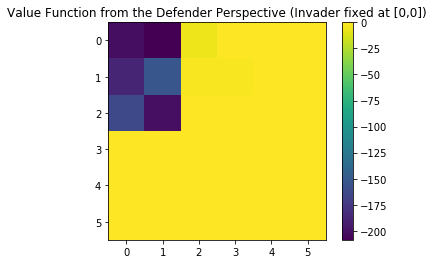

In [24]:
# create a list of states that fixes the invaders's starting position
fixed_invader_state_list = []
for defender_state in invader_defender.states:
    fixed_invader_state = tuple(defender_state + [0, 0])
    fixed_invader_state_list.append(fixed_invader_state)
# create invader heatmap
defender_map = np.zeros([6,6])
for state in fixed_invader_state_list:
    defender_map[state[0], state[1]] = np.mean(Q_state_dict[state])*-1

# if invader is fixed at top left corner, this heatmap shows the defender's rewards
plt.imshow(defender_map, interpolation='nearest')
plt.colorbar()
plt.title('Value Function from the Defender Perspective (Invader fixed at [0,0])')
plt.show()

## Defender and Invader Policy 

In [25]:
# policy extraction
for state in invader_defender.game_state_list:    
    G[state] = calculate_payoff(state)
    defender_policy[state],invader_policy[state] = equilibrium(G[state])

In [26]:
defender_policy

{(0, 0, 0, 0): array([0., 0., 1., 0.]),
 (0, 0, 0, 1): array([1., 0., 0., 0.]),
 (0, 0, 0, 2): array([1., 0., 0., 0.]),
 (0, 0, 0, 3): array([1., 0., 0., 0.]),
 (0, 0, 0, 4): array([1., 0., 0., 0.]),
 (0, 0, 0, 5): array([1., 0., 0., 0.]),
 (0, 0, 1, 0): array([0.56746874, 0.        , 0.43253126, 0.        ]),
 (0, 0, 1, 1): array([1., 0., 0., 0.]),
 (0, 0, 1, 2): array([1., 0., 0., 0.]),
 (0, 0, 1, 3): array([1., 0., 0., 0.]),
 (0, 0, 1, 4): array([1., 0., 0., 0.]),
 (0, 0, 1, 5): array([1., 0., 0., 0.]),
 (0, 0, 2, 0): array([0.        , 0.04102814, 0.08848771, 0.87048415]),
 (0, 0, 2, 1): array([0.10783246, 0.08962376, 0.80254378, 0.        ]),
 (0, 0, 2, 2): array([1., 0., 0., 0.]),
 (0, 0, 2, 3): array([1., 0., 0., 0.]),
 (0, 0, 2, 4): array([1., 0., 0., 0.]),
 (0, 0, 2, 5): array([1., 0., 0., 0.]),
 (0, 0, 3, 0): array([1., 0., 0., 0.]),
 (0, 0, 3, 1): array([1., 0., 0., 0.]),
 (0, 0, 3, 2): array([1., 0., 0., 0.]),
 (0, 0, 3, 3): array([1., 0., 0., 0.]),
 (0, 0, 3, 4): array([1.

In [27]:
invader_policy

{(0,
  0,
  0,
  0): array([0.00000000e+00, 0.00000000e+00, 2.77555756e-17, 1.00000000e+00]),
 (0,
  0,
  0,
  1): array([3.94430453e-31, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 (0, 0, 0, 2): array([1., 0., 0., 0.]),
 (0, 0, 0, 3): array([1., 0., 0., 0.]),
 (0, 0, 0, 4): array([1., 0., 0., 0.]),
 (0, 0, 0, 5): array([1., 0., 0., 0.]),
 (0, 0, 1, 0): array([0.        , 0.18518774, 0.81481226, 0.        ]),
 (0, 0, 1, 1): array([0., 1., 0., 0.]),
 (0, 0, 1, 2): array([1., 0., 0., 0.]),
 (0, 0, 1, 3): array([1., 0., 0., 0.]),
 (0, 0, 1, 4): array([1., 0., 0., 0.]),
 (0, 0, 1, 5): array([1., 0., 0., 0.]),
 (0, 0, 2, 0): array([0.        , 0.04768556, 0.49224456, 0.46006987]),
 (0, 0, 2, 1): array([0.        , 0.03172695, 0.70311668, 0.26515637]),
 (0, 0, 2, 2): array([1., 0., 0., 0.]),
 (0, 0, 2, 3): array([1., 0., 0., 0.]),
 (0, 0, 2, 4): array([1., 0., 0., 0.]),
 (0, 0, 2, 5): array([1., 0., 0., 0.]),
 (0, 0, 3, 0): array([1., 0., 0., 0.]),
 (0, 0, 3, 1): array([1., 0., 0., 0.

## Play the game

In [29]:
def generate_trajectory(Defender_state, Invader_state):
    
    terminal = False
    generated = False
    
    # while not successful generation, repeat
    while not generated:
        game_step = 0
        current_state = tuple(Defender_state + Invader_state)
        game_trajectory = []
        # generate a game trajectory
        while not terminal:
            
            generated = True
            
            # append game trajectory
            game_trajectory.append(current_state)

            # check if game is terminal (someone won)
            terminal, status = invader_defender.terminal_check(list(current_state))

            # both agents choose action based on policy via sampling
            invader_action = actions[int(np.random.choice(action_count, 1, p=invader_policy[tuple(current_state)]))]
            defender_action = actions[int(np.random.choice(action_count, 1, p=defender_policy[tuple(current_state)]))]
            
            # obtain next state
            next_state, reward = invader_defender.next_state(list(current_state), defender_action, invader_action)
            current_state = tuple(next_state)

            game_step += 1
            clear_output(wait=True)
            display("game step: " + str(game_step))
            
            # exit the game if the game steps increase pass 100 (implying agents are stuck)
            if game_step > 100:
                generated = False
                break
    
    return game_trajectory, status
# generate game trajectory
game_trajectory, status = generate_trajectory([5,0],[0,0])
# define game dimensions
columns=range(invader_defender.size)
index = range(invader_defender.size)

# animate the game
for step in range(len(game_trajectory)):
    game_table = pd.DataFrame(0, index = index, columns=columns)
    game_table[4][4] = 'Ter.'
    game_table[game_trajectory[step][1]][game_trajectory[step][0]] = 'DEF'
    game_table[game_trajectory[step][3]][game_trajectory[step][2]] = 'INV'
    clear_output(wait=True)
    display(game_table)
    time.sleep(0.2)
    
# print game status
display(status)

'game step: 4'

ValueError: probabilities are not non-negative